In [1]:
import numpy as np
import pandas as pd
from dobbel import dobbellogger
dob = dobbellogger()

In [12]:
dob.connect()
dob.log(5, 100, 4, 250)
dob.download()
data = dob.datadf

Logging data for 5s
Done! The data is located in self.datadf


In [13]:
def expq(vector, multiplier=1):
    x, y, z = vector[0] * multiplier, vector[1] * multiplier, vector[2]  * multiplier
    absq = (x ** 2 + y ** 2 + z ** 2) ** 1/2
    w = np.cos(absq)
    sinabs = np.sin(absq)
    xq = x * sinabs / absq
    yq = y * sinabs / absq
    zq = z * sinabs / absq
    return np.array([w, xq, yq, zq])

In [14]:
def quat_mul(p, q):
    p0 = p[0]
    q0 = q[0]
    pv = p[1:]
    qv = q[1:]
    out0 = p0 * q0 - np.dot(pv, qv)
    outv = p0 * qv + q0 * pv + np.cross(pv, qv)
    out = np.array([out0, *outv])
    return out

In [15]:
def quaternion_conjugate(q):
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

In [16]:
# Actual Rotation Fuction - Input = Acceleration vector = 1x3 , rotation_quaternion = 1*4
def rotate_vector(vector, rotation_quaternion):
    # Convert the vector to a quaternion
    vector_quaternion = np.concatenate(([0], vector))

    # Calculate the rotated quaternion
    rotated_quaternion = quat_mul(rotation_quaternion, quat_mul(vector_quaternion, quaternion_conjugate(rotation_quaternion)))

    # Extract the rotated vector from the quaternion
    rotated_vector = rotated_quaternion[1:]

    return np.array(rotated_vector)

In [17]:
def quat_to_euler(q):
    w, x, y, z = q[0], q[1], q[2], q[3]
    psi = np.arctan((2*x*y-2*w*z)/((2*w**2)+(2*x**2)-1))
    theta = -np.arcsin(2*x*z+2*w*y)
    phi = np.arctan((2*y*z-2*w*x)/((2*w**2)+(2*z**2)-1))
    return np.array([psi, theta, phi])

In [18]:
def remove_nan(df):
    counter = 0
    nan = True
    while nan:
        if not df.loc[counter].isna().any():
            nan = False
        counter += 1
    for i in range(counter - 1):
        df = df.drop(index=i)
    df = df.reset_index(drop=True)
    counter = len(df) - 1
    nan = True
    while nan:
        if not df.loc[counter].isna().any():
            nan = False
        counter -= 1
    maxlen = len(df)
    for i in range(maxlen - 1, counter + 1, -1):
        df = df.drop(index=i)
    df = df.reset_index(drop=True)
    for i in range(len(df)):
        df['timestamp'][i] = df['timestamp'][i] - df['timestamp'][0]
    for i in range(len(df)):
        for column in df.columns:
            if np.isnan(df[column][i]):
                deler = (df['timestamp'][i] - df['timestamp'][i - 1]) / (df['timestamp'][i + 1] - df['timestamp'][i - 1])
                df[column][i] = df[column][i - 1] + deler * (df[column][i + 1] - df[column][i - 1])
    return df

In [19]:
def left_quat_mul(q):
    q0, q1, q2, q3 = q
    lqm = np.array([
        [q0, -q1, -q2, -q3],
        [q1, 1, -q3, -q2],
        [q2, q3, 1, -q1],
        [q3, -q2, q1, 1]
    ])
    return lqm

def right_quat_mul(q):
    q0, q1, q2, q3 = q
    lqm = np.array([
        [q0, -q1, -q2, -q3],
        [q1, 1, q3, q2],
        [q2, -q3, 1, q1],
        [q3, q2, -q1, 1]
    ])
    return lqm

In [ ]:
def rotate_data(data):
    angle = np.deg2rad(-39)
    rotate_y = np.array([[np.cos(angle),0,np.sin(angle)], [0,1,0],[-np.sin(angle),0,np.cos(angle)]])
    trace = np.trace(rotate_y)
    q_0 = np.sqrt(1+trace)/2
    q_2 = 1/(4*q_0) * (np.sin(angle)+np.sin(angle))
    q_rotate = np.array([q_0,0,q_2,0])
    for i, row in data.iterrows():
        data.loc[i, 'x_acc'], data.loc[i, 'y_acc'], data.loc[i, 'z_acc'] = rotate_vector(np.array([row['x_acc'], row['y_acc'], row['z_acc']]), q_rotate)
        data.loc[i, 'x_gyro'], data.loc[i, 'y_gyro'], data.loc[i, 'z_gyro'] = rotate_vector(np.array([row['x_gyro'], row['y_gyro'], row['z_gyro']]), q_rotate)

In [20]:
# Deze code niet vaker dan 1 keer uitvoeren!
data = remove_nan(data)
data = rotate_data(data)
    
gyro_bias = [-0.15011551, 0.46386851, -0.06026889]
acc_bias = [ 0.00095061, 0.02617323, -0.04702061]

data['x_gyro'] = data['x_gyro'] - gyro_bias[0]
data['y_gyro'] = data['y_gyro'] - gyro_bias[1]
data['z_gyro'] = data['z_gyro'] - gyro_bias[2]
data['x_acc'] = data['x_acc'] - acc_bias[0]
data['y_acc'] = data['y_acc'] - acc_bias[1]
data['z_acc'] = data['z_acc'] - acc_bias[2]

In [21]:
data.head(1000)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,0.988877,-0.049245,0.015283,0.019544,-0.181856,-0.202388
1,10.0,0.997181,-0.049855,0.013369,-0.017735,-0.136125,0.061653
2,21.0,0.997132,-0.050709,0.012072,0.029942,0.046802,0.051223
3,31.0,0.998519,-0.052052,0.012881,0.031069,-0.029417,0.061943
4,41.0,0.996694,-0.054371,0.012032,-0.032962,0.001071,0.019900
...,...,...,...,...,...,...,...
501,4878.0,0.995035,-0.050221,0.015244,0.030521,-0.014173,-0.046384
502,4888.0,0.996513,-0.047780,0.013613,0.020381,-0.227588,-0.142864
503,4899.0,0.999784,-0.047169,0.011707,0.039278,-0.227588,-0.117754
504,4909.0,0.995582,-0.048878,0.013016,-0.078932,-0.151369,-0.056557


In [164]:


y11 = np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
mb = np.array([1, 0, 0])
A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) - np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))



# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]

print(max_eigenvector)

[ 0.95456865 -0.12365515  0.26935115 -0.03095256]


In [165]:
for column in data.columns:
    print(column, max(data[column]))

timestamp 4927.0
x_acc -0.9666758531514144
y_acc -0.013916015625000002
z_acc -0.007374138501674565
x_gyro 0.09789665517237431
y_gyro 0.6935975551605225
z_gyro 0.19518139077380708


In [166]:
qtmin1tmin1 = max_eigenvector

dqde = np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [np.pi / 9, 0, 0],
    [0, np.pi / 9, 0],
    [0, 0, np.pi / 9]
])

Ptmin1tmin1 = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(qtmin1tmin1), dqde), sigma_etha), dqde.T), right_quat_mul(qtmin1tmin1))

In [167]:
qtmin1tmin1 = np.reshape(qtmin1tmin1, 4)

v = np.array([0, 0, 0])
p = np.array([0, 0, 0])
q_list = [qtmin1tmin1]
p_list = [p]
v_list = [v]

# std van gyroscope
Q = np.array([
    [0.0152682, 0, 0],
    [0, 0.063694, 0],
    [0, 0, 0.11032866]
])

# std van accelerometer
R = np.array([
    [0.00206182, 0, 0],
    [0, 0.00153152, 0],
    [0, 0, 0.00226686],
])

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement # - gyro_bias
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)
    
    Ftmin1 = right_quat_mul(expq_omega)
    Gtmin1 = - 0.5 * dt * np.matmul(left_quat_mul(qtmin1tmin1), dqde)
    
    Pttmin1 = np.matmul(np.matmul(Ftmin1, Ptmin1tmin1), Ftmin1.T) + np.matmul(np.matmul(Gtmin1, Q), Gtmin1.T)
    
    qttmin1 = quat_mul(qtmin1tmin1, expq_omega)
    
    q0, q1, q2, q3 = quaternion_conjugate(qttmin1)
    # Zou kunnen dat hier de geconjugeerde genomen moet worden!!
    H = np.array([
        [2 * q2, 2 * q3, 2 * q0, 2 * q1],
        [-2 * q1, -2 * q0, 2 * q3, 2 * q2],
        [4 * q0, 0, 0, 4 * q3]
    ])
    S = np.matmul(np.matmul(H, Pttmin1), H.T) + R
    K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))
    
    yat = np.array([data['x_acc'][i], data['y_acc'][i], data['z_acc'][i]]) # - acc_bias
    yattmin1 = - rotate_vector(gn, quaternion_conjugate(qttmin1)) # Zou kunnen dat hier een min achter moet!!! en geconjugeerde
    epsilon = yat - yattmin1
    print(data['timestamp'][i], epsilon)

    q_tt_measure = np.reshape(qttmin1, (4, 1)) + np.matmul(K, np.reshape(epsilon, (3, 1)))
    P_tt_measure = Pttmin1 - np.matmul(np.matmul(K, S), K.T)
    
    qtt = q_tt_measure / ((np.linalg.norm(q_tt_measure)))
    #J = np.matmul(q_tt_measure, q_tt_measure.T) / (np.linalg.norm(q_tt_measure) ** 3)
    Ptt = P_tt_measure #np.matmul(np.matmul(J, P_tt_measure), J.T)
    
    Pttmin1 = Ptt
    qtmin1tmin1 = np.reshape(qtt, 4)
    
    q_list.append(qtmin1tmin1)
    

20.0 [-1.50654906 -0.31096657  0.84749957]
29.0 [-0.4063814   0.12848975  0.80272707]
39.0 [-0.19916411 -0.22581479  0.58963831]
50.0 [-0.05981509  0.0905238   0.31449436]
60.0 [-0.01025274  0.083644    0.12768384]
70.0 [-0.00694088 -0.03219677  0.04744038]
80.0 [-0.00469779  0.00806569  0.01545983]
91.0 [0.00150442 0.00568811 0.00185981]
101.0 [-6.88611711e-03 -4.18885093e-05  2.67981331e-03]
110.0 [-0.00841047  0.00119492 -0.00189831]
120.0 [-0.00058426  0.00043898 -0.00642118]
130.0 [-0.00780276  0.0017741  -0.00164418]
140.0 [-0.00338999 -0.00300054 -0.00258952]
151.0 [-0.0032971   0.0006971  -0.00410078]
161.0 [-0.0025311  -0.00249703 -0.00131166]
171.0 [-0.00581097  0.00047143 -0.00159657]
180.0 [-0.00414294  0.00144646 -0.00511491]
190.0 [-0.00059863 -0.00152258 -0.00174483]
200.0 [-0.00151445  0.00190417 -0.00162926]
211.0 [-0.00510182  0.00086226  0.00062974]
221.0 [-0.00326865 -0.00157454 -0.00309525]
231.0 [-0.00090943  0.00289367 -0.00420101]
241.0 [-7.94309349e-03 -5.08227

In [168]:
euler_x = []
euler_y = []
euler_z = []

for q, timestamp in zip(q_list, data['timestamp']):
    euler = quat_to_euler(q) * 180 / np.pi
    print(timestamp, euler)
    euler_x.append(euler[0])
    euler_y.append(euler[1])
    euler_z.append(euler[2])

0.0 [ -0.50515514 -31.45865839  14.90429647]
20.0 [25.01661406 38.26898457  4.74046914]
29.0 [-74.20653856  33.91999169 -46.75398132]
39.0 [-60.16337391  49.58889574 -63.24464986]
50.0 [17.36259911 83.81962226  9.06464322]
60.0 [-87.22149527  37.76258878 -87.93633879]
70.0 [-86.41757093  39.29701764  89.62113014]
80.0 [-87.32620797  40.85270926  88.68777577]
91.0 [-87.69532136  41.48278215  88.64214261]
101.0 [-87.8580397   41.26236418  88.26138677]
110.0 [-87.97421241  40.5971301   88.07176024]
120.0 [-87.82610088  40.00263915  88.38756157]
130.0 [-87.97374374  39.46353922  88.20458615]
140.0 [-87.76421726  38.83525495  88.22040356]
151.0 [-87.73639161  38.31630602  88.31437358]
161.0 [-87.58365418  37.89667647  88.29213794]
171.0 [-87.63060653  37.43832592  88.17475655]
180.0 [-87.63468573  36.84850763  88.28882567]
190.0 [-87.51182525  36.57776046  88.35147299]
200.0 [-87.60112181  36.47075614  88.38166064]
211.0 [-87.7094854   36.27905671  88.17969074]
221.0 [-87.57750751  35.74391

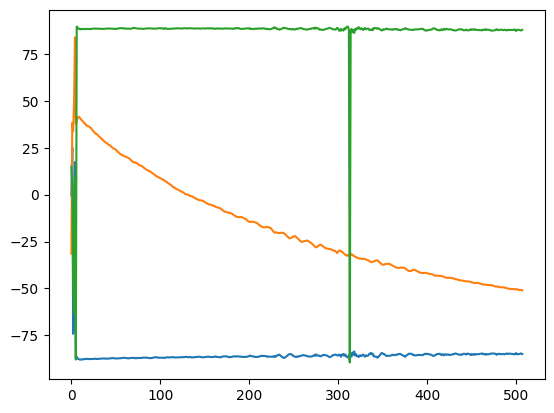

In [169]:
import matplotlib.pyplot as plt

plt.plot(euler_x)
plt.plot(euler_y)
plt.plot(euler_z)